# Lab ML for DS SS23
## Project 2
#### Jan Jascha Jestel (5547158)
#### Mustafa Suman (5564676)
#### Gabriele Inciuraite (5208806)

In [4]:
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns

from scipy.io import loadmat
from scipy.spatial.distance import pdist
from scipy.stats import norm

from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

from itertools import combinations_with_replacement, combinations


# 1. Importing the QM7 Dataset

In [5]:
# The QM7 dataset consists of 7165 organic molecules, each of which is composed of up to 23 atoms.
qm7 = loadmat("./qm7.mat")
print(qm7.keys())

dict_keys(['__header__', '__version__', '__globals__', 'X', 'R', 'Z', 'T', 'P'])


In [6]:
# R (7165×23×3) contains for each molecule and atom a triplet representing the 3d coordinates
display(qm7['R'].shape)
display(qm7['R'][0])

(7165, 23, 3)

array([[ 1.886438  , -0.00464873, -0.00823921],
       [ 3.9499245 , -0.00459203,  0.00782347],
       [ 1.1976895 ,  1.9404842 ,  0.00782347],
       [ 1.1849339 , -0.99726516,  1.6593875 ],
       [ 1.2119948 , -0.9589793 , -1.710958  ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.   

In [7]:
# Z (7165×23) contains for each molecule and atom of the molecule the corresponding atomic number

# 0 == no atom at this index
# 1 == hydrogen (H) 1
# 6 == carbon (C) 4
# 7 == nitrogen (N) 3
# 8 == oxygen (O) 2
# 16 == sulfur (S) 6
display(qm7['Z'].shape)
display(qm7['Z'][0])

(7165, 23)

array([6., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0.], dtype=float32)

(1, 7165)

-417.96

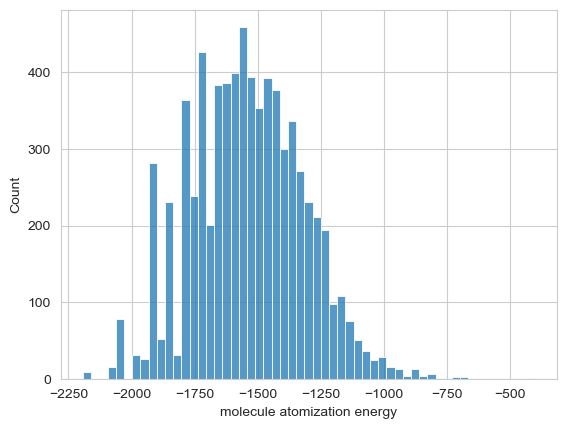

In [9]:
# T (1 x 7165) contains for each molecule the atomization energy (computed via quantum-chemical simulation)
display(qm7['T'].shape)
display(qm7['T'][0, 0])

g = sns.histplot(qm7['T'][0])
g.set_xlabel('molecule atomization energy')
plt.show()

# 1.1 Visualizing Molecules

### "quick and dirty approach"

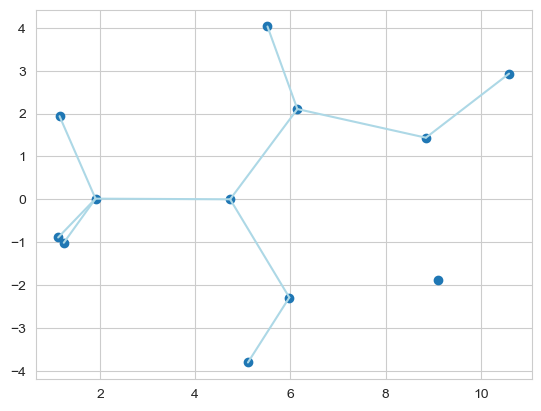

In [10]:
nr = 6432

mol = qm7["R"][nr]
sym = qm7["Z"][nr]

sym = sym[sym > 0]
mol = mol[: len(sym)]

plt.scatter(x=mol[:, 0], y=mol[:, 1])


# generate bonds
thresh = 3

mask = np.argwhere(pdist(mol, metric="euclidean") < thresh)[:, 0]
bonds = np.vstack(np.triu_indices(len(mol), 1)).T[mask]

for i in range(len(bonds)):
    plt.plot(mol[bonds[i]][:, 0], mol[bonds[i]][:, 1], color="lightblue")


Observation: In this 2-D visualisation we chose a fixed threshold of three. This works well enough for many bonds, but not for all of them. Different atoms have different bond lengths: as can be seen in this particular example, one atom is further away from the others. In addition to that, some atoms have multiple bonds which is not expressed in the visualisation.

### Atomic Simulation Environment

In [11]:
from ase import Atoms
import nglview
import ase.visualize

system = Atoms(positions=mol, symbols=sym)
# ase.visualize.view(system, viewer="x3d")

view = nglview.show_ase(system)
view.add_ball_and_stick() # HOW TO SPECIFY BONDS?????
view

# Other viz approaches
# https://www.kaggle.com/code/mykolazotko/3d-visualization-of-molecules-with-plotly
# nglview

NGLWidget()

# 2. Data Representation, ML Model and Explanations

# 2.1 Data Representation

We first decomposed the molecules into individual elements - atoms - and saved a representation of each molecule as an array with the counts of each atom type.

In [29]:
# one hot encoding of [HCNOS]

# 1 == hydrogen (H)
# 6 == carbon (C)
# 7 == nitrogen (N)
# 8 == oxygen (O)
# 16 == sulfur (S)

z = qm7["Z"].astype(np.int8)

z[z == 1] = 1
z[z == 6] = 2
z[z == 7] = 3
z[z == 8] = 4
z[z == 16] = 5

Z_hot = np.eye(6)[z]
Z_hot = Z_hot[:, :, 1:]  # drop 0 dimension

# sum of to create the representation
x = np.sum(Z_hot, axis=1).astype(int)

print("Shape:", x.shape)
print("Resulting representations:")
print(x)


Shape: (7165, 5)
Resulting representations:
[[ 4  1  0  0  0]
 [ 6  2  0  0  0]
 [ 4  2  0  0  0]
 ...
 [ 9  6  1  0  0]
 [10  7  0  0  0]
 [12  7  0  0  0]]


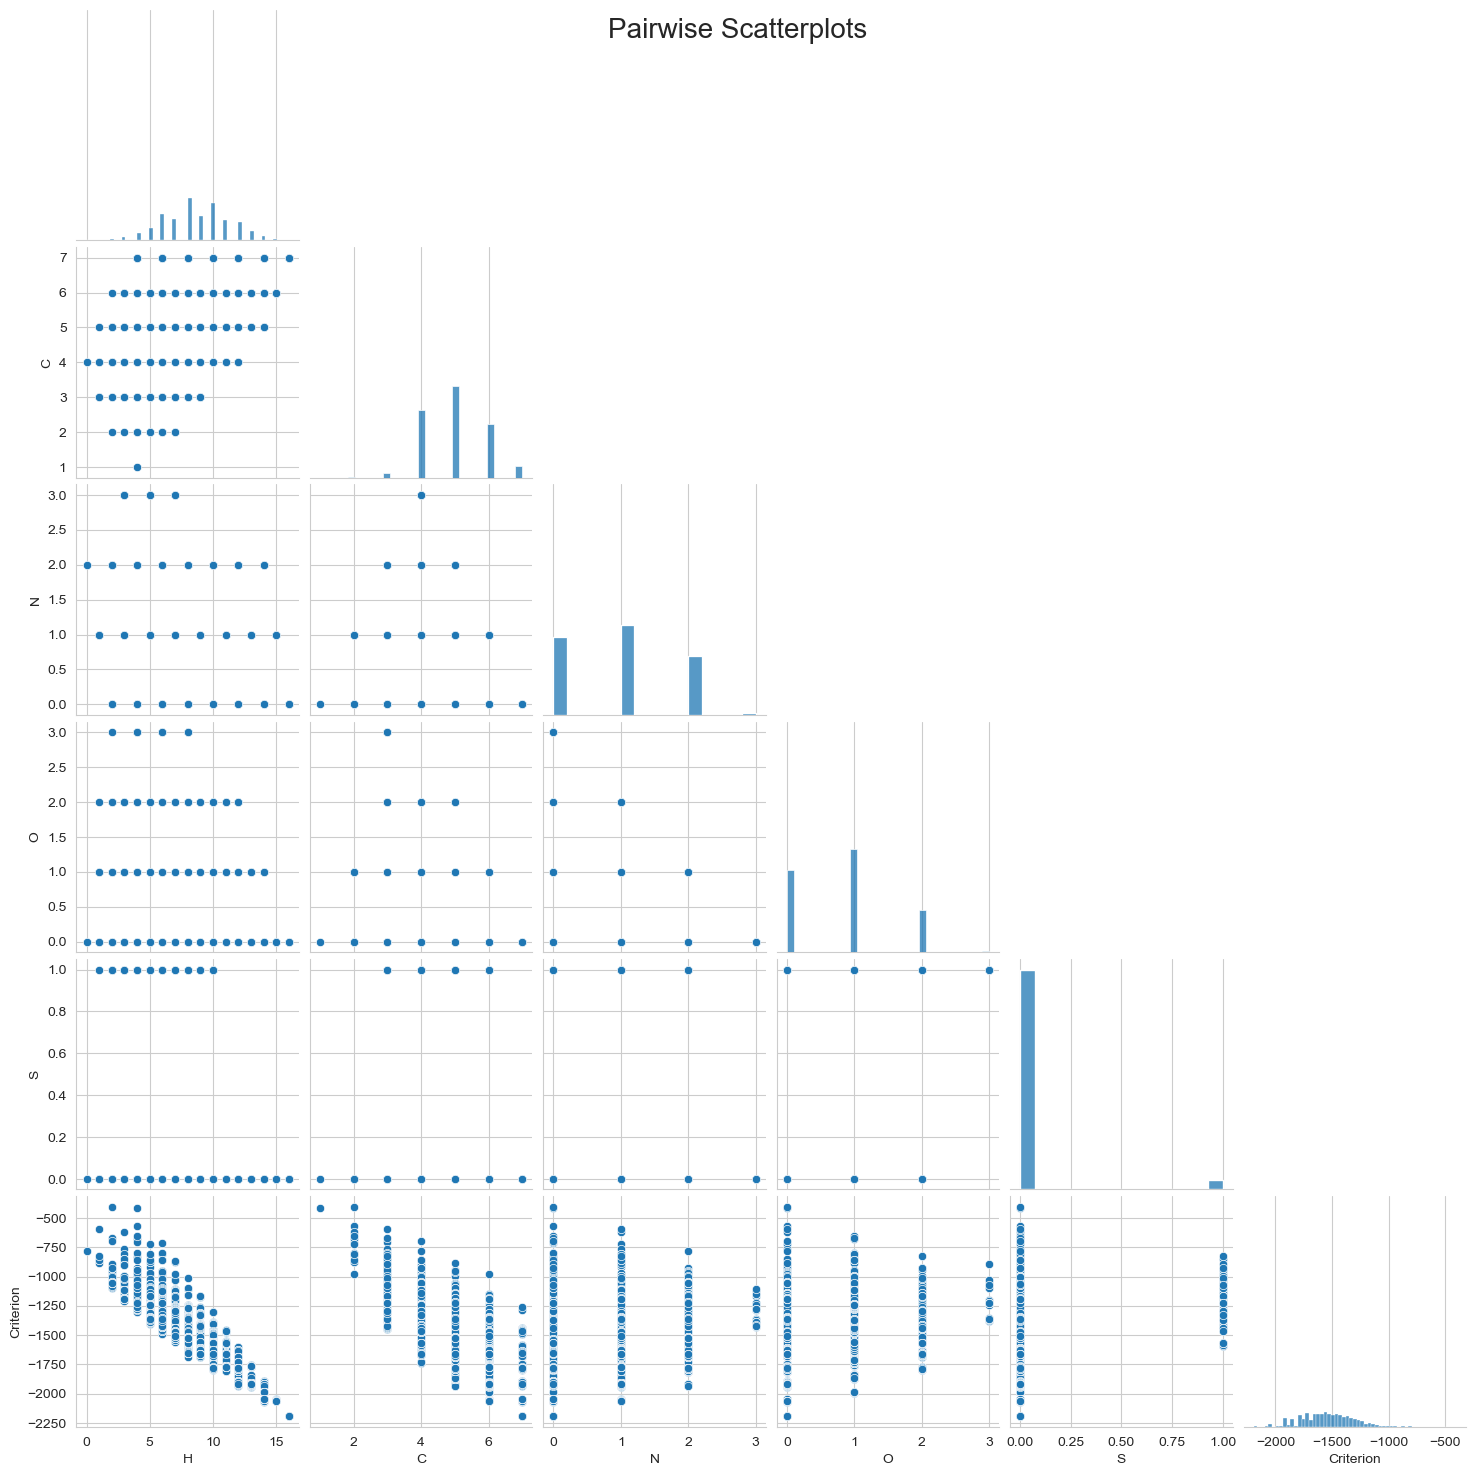

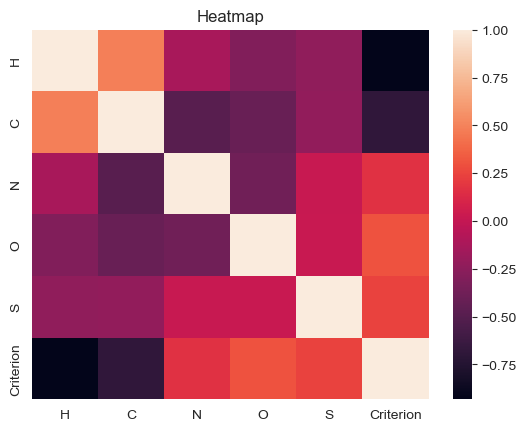

In [66]:
import pandas as pd

y = np.reshape(qm7["T"][0], (-1, 1))
df = pd.DataFrame(np.concatenate((x, y), axis=1), columns = ["H", "C", "N", "O", "S", "Criterion"])

sns.pairplot(df, corner=True)
plt.suptitle("Pairwise Scatterplots", fontsize=20)
plt.show()

sns.heatmap(df.corr(numeric_only=False))
plt.title("Heatmap")
plt.show()

In [67]:
print(df.corr())

                  H         C         N         O         S  Criterion
H          1.000000  0.483864 -0.125100 -0.298140 -0.236983  -0.931799
C          0.483864  1.000000 -0.486695 -0.413210 -0.225661  -0.688390
N         -0.125100 -0.486695  1.000000 -0.373496  0.017874   0.169763
O         -0.298140 -0.413210 -0.373496  1.000000  0.025079   0.299107
S         -0.236983 -0.225661  0.017874  0.025079  1.000000   0.243362
Criterion -0.931799 -0.688390  0.169763  0.299107  0.243362   1.000000


Observation: The pairwise scatterplots and correlation matrix reveal a lack of multicollinearity in the data - the predictor variables are not highly correlated with one another, except for hydrogen and carbon (corr = 0.48).
We can also see a strong linear relationship between the atomisation energy and hydrogen (corr = -0.93) as well as carbon (corr = -0.69).


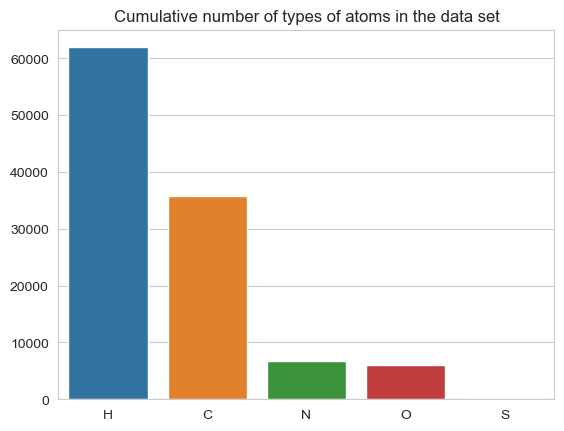

In [68]:
g = sns.barplot(x=["H", "C", "N", "O", "S"], y=np.sum(x, axis=0))
g.set_title('Cumulative number of types of atoms in the data set')
plt.show()

Observation: It is worth noting that hydrogen and carbon are the most common atoms in the data set.

# 2.2 Ridge Regression Model

We then split the data into train and test subsets and centered numbers of the atoms in the molecules.

In [69]:
def split_and_center(X, y, test_size, shuffle=True):
    # split train / test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42, shuffle=shuffle)

    # center data and target
    X_train_mean = np.mean(X_train, axis=0)
    y_train_mean = np.mean(y_train)
    print(X_train_mean)

    X_train = X_train - X_train_mean
    X_test = X_test - X_train_mean

    y_train = y_train - y_train_mean
    y_test = y_test - y_train_mean

    return X_train, X_test, y_train, y_test



X_train, X_test, y_train, y_test = split_and_center(x, qm7["T"][0], test_size=0.3)

[8.61894317 4.98703888 0.92961117 0.83808574 0.04287139]


In order to tune the regularisation parameter alpha for the Ridge regression model, we performed a grid search on the training data.

In [87]:
# Grid search to tune alpha using 10-fold cross validation

ridge = Ridge()
alpha_values = np.logspace(np.log10(1e-4), np.log10(100), num=100)
grid = dict(alpha=alpha_values)
search = GridSearchCV(
    ridge,
    grid,
    scoring=("neg_mean_absolute_error"), # 'r2', 'neg_mean_squared_error'
    cv=10,
    n_jobs=-1,
    refit="neg_mean_absolute_error",
    return_train_score=True,
)  

results = search.fit(X_train, y_train)


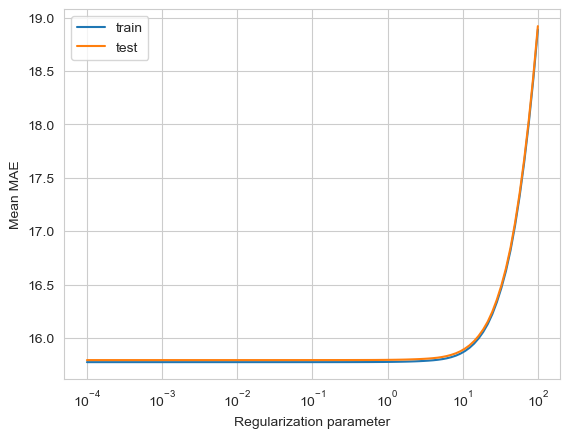

In [88]:
ax = sns.lineplot(x=alpha_values, y = -results.cv_results_['mean_train_score'], label='train')
ax = sns.lineplot(x=alpha_values, y = -results.cv_results_['mean_test_score'], label='test')
ax.set_xscale('log')
ax.set_xlabel('Regularization parameter')
ax.set_ylabel('Mean MAE')
plt.legend(loc='upper left')
plt.show()

Observation: Low regualarisation parameters achieve the best MAE

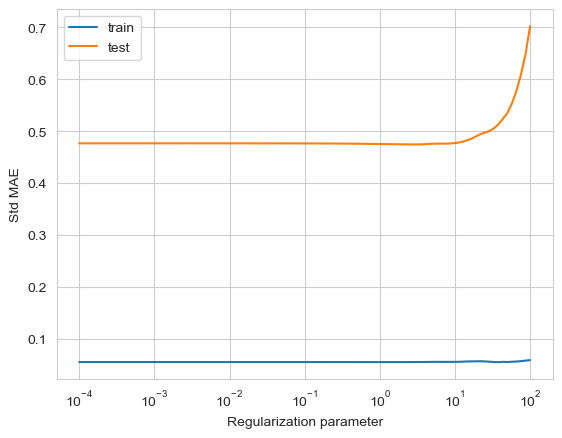

In [74]:
ax = sns.lineplot(x=alpha_values, y = results.cv_results_['std_train_score'], label='train')
ax = sns.lineplot(x=alpha_values, y = results.cv_results_['std_test_score'], label='test')
ax.set_xscale('log')
ax.set_xlabel('Regularization parameter')
ax.set_ylabel('Std MAE')
plt.legend(loc='upper left')
plt.show()

Observation: The standard deviation of the absolute error is very low and stable for low regualarisation parameters.

We plotted the regression model using the very low regularisation parameter (alpha= 0.0001) which resulted in our parameter tuning.

Best parameter: {'alpha': 0.0001}
R2: 0.992
MAE: 15.461
MSE: 403.582


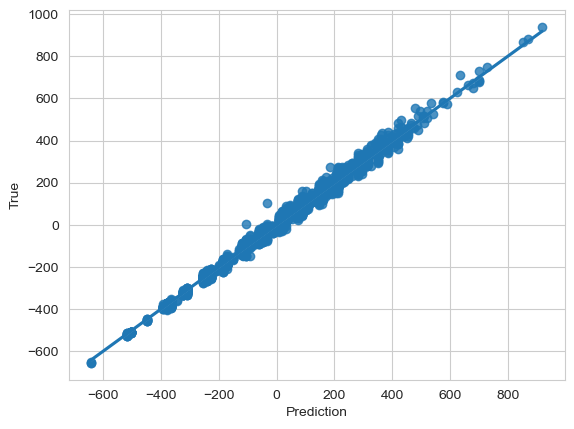

In [82]:
y_pred = search.best_estimator_.predict(X_test)
print("Best parameter:", results.best_params_)
print(f"R2: {r2_score(y_test, y_pred):.3f}")
print(f"MAE: {mean_absolute_error(y_test, y_pred):.3f}")
print(f"MSE: {mean_squared_error(y_test, y_pred):.3f}")
g = sns.regplot(x=y_pred, y=y_test)
g.set_xlabel("Prediction")
g.set_ylabel("True")
plt.show()

Since the regularisation parameter is so small we compared the results with performing a linear regression without regularisation.

R2: 0.992
MAE: 15.461
MSE: 403.582


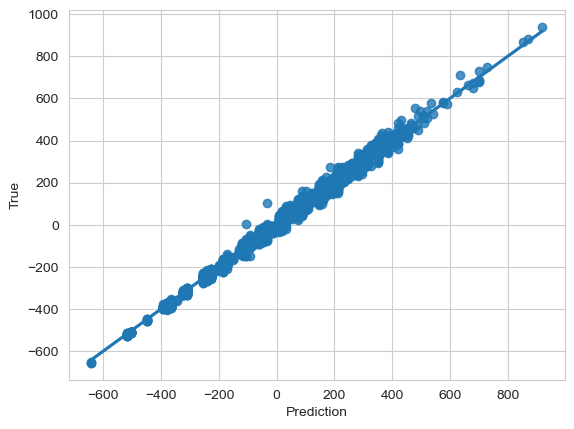

In [84]:
lr = LinearRegression().fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)
print(f"R2: {r2_score(y_test, y_pred_lr):.3f}")
print(f"MAE: {mean_absolute_error(y_test, y_pred_lr):.3f}")
print(f"MSE: {mean_squared_error(y_test, y_pred_lr):.3f}")

g = sns.regplot(x=y_pred_lr, y=y_test)
g.set_xlabel("Prediction")
g.set_ylabel("True")
plt.show()

Observation: The explained variance and error scores for these two regression models are identical. Taken together with the tendency for the Ridge model to perform increasingly worse with higher regularisation term, we conclude that the ridge regression introduces bias in the estimation of the atomisation energy instead of improving it.
We can attribute this to a few factors. First of all, we did not observe high multicolinearity in the data. In the absence of multicolinearity, linear reression tends to perform equally well or even better than Ridge regression.
Secondly, the most common atoms in the data, hydrogen and carbon, had a high linear relationship with the criterion. We therefore conclude that the underlying relationship in the data is highly linear. Without non-linearities and interactions, Ridge regression tends to introduce bias in the estimates, which may not be necessary given the true relationship is linear.
Lastly, this representation of the data is low-dimensional, which is an additional reason why Ridge regression might not offer much imporvement compared to linear regression.

We also observed that the explained variance is very high, even when fitting the regression to a low number of data points. This, too, points to a strong linear relationship between the independent and dependent variables.

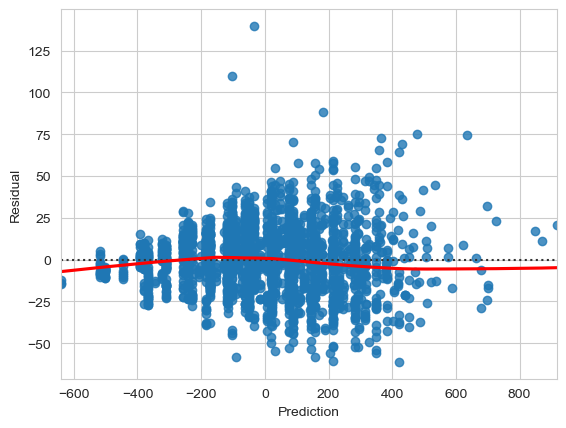

In [89]:
g = sns.residplot(x=y_pred, y=y_test, lowess=True, line_kws=dict(color="r"))
g.set_xlabel("Prediction")
g.set_ylabel("Residual")
plt.show()


In [90]:
# TODO add plot how the weights change with different alpha

# 2.3 Deeper Insights with Explanations 
# 3. Experiments 
# 3.1 Simple atom-based Representation

In [66]:
print(f"MAE: {mean_absolute_error(y_test, search.best_estimator_.predict(X_test)):.3f}")
print("Ri:", search.best_estimator_.coef_)


MAE: 15.461
Ri: [ -68.68727583 -157.410442   -102.41624528 -101.15629173  -80.54594189]


<Axes: >

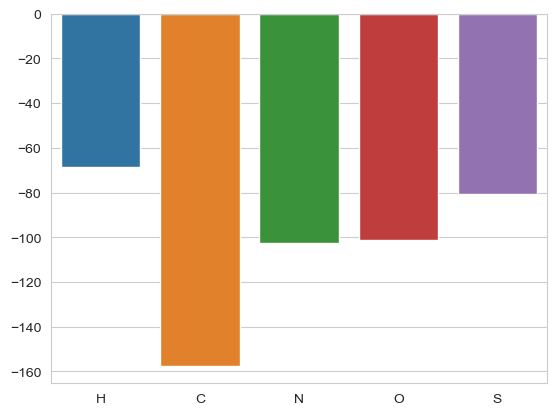

In [64]:
sns.barplot(x=["H", "C", "N", "O", "S"], y=search.best_estimator_.coef_)
# TODO Compare the produced insights with existing chemical knowledge or the literature.

# 1 == hydrogen (H) 1
# 6 == carbon (C) 4
# 7 == nitrogen (N) 3
# 8 == oxygen (O) 2
# 16 == sulfur (S) 6

In [68]:
np.mean(x, axis=0)

array([8.6474529 , 4.99106769, 0.92882066, 0.83433357, 0.0414515 ])

In [69]:
np.var(x, axis=0)

array([6.52079079, 0.82280926, 0.62242827, 0.53515059, 0.03973327])

# 3.2 Models with Pairs of Atoms

In [70]:
# create dictionary to translate atom combinations to number between 0 and 14
d = {c: i for i, c in enumerate(combinations_with_replacement([1, 2, 3, 4, 5], r=2))}

# add inverse tuples pointing to same number
inv = {}
for c in d:
    inv[c[1], c[0]] = d[c]

# merge dictionaries
d = d | inv
del inv

In [71]:
# generate arrays with the distances and the types of all pairs
N_COMB = 824783
pair_dist = np.zeros(N_COMB) # all distances
pair_type = np.zeros(N_COMB).astype(int) # all types
mol_split = np.zeros(7165 + 1).astype(int) # indices where to split the array to get the molecules
pair_idx = 0

for i in range(len(z)):
    sym = z[i]
    sym = sym[sym != 0]
    mol = qm7["R"][i][: len(sym)]

    dist = pdist(mol, metric="euclidean")
    comb = [*combinations(sym, r=2)]
    n_combs = len(comb)
    
    pair_dist[pair_idx : pair_idx + n_combs] = dist
    pair_type[pair_idx : pair_idx + n_combs] = [d[x] for x in comb]

    mol_split[i] = pair_idx
    pair_idx += n_combs

mol_split[-1] = N_COMB

In [72]:
def generate_representaions(THETA_1, THETA_M, STD, M, soft = True):

    intervals = np.linspace(THETA_1, THETA_M, M)
    interval_size = (THETA_M - THETA_1) / (M - 1)
    interval_centeres = intervals[:-2] + interval_size

    # generate phi_A(Ei) using specified hard or soft encoding
    phi_A = np.zeros((len(pair_dist), M))

    if soft:
        for j, mu in enumerate(interval_centeres):
            phi_A[:, j] = norm.pdf(pair_dist, loc=mu, scale=STD)
    else: 
        indices = np.floor((pair_dist - THETA_1) / interval_size).astype(int)
        phi_A[indices < M] = np.eye(M)[indices[indices < M]]

    # generate phi_B(Ei)
    phi_B = np.eye(15)[pair_type].astype(int)

    # generate phi(Ei)
    phi_AB = phi_A[:, :, None] * phi_B[:, None, :]
    phi_AB = phi_AB.reshape(N_COMB, -1)

    # aggregate for molecule representation
    reps = np.zeros((len(z), M * 15))
    for i in range(len(mol_split)):
        reps[i - 1, :] = np.sum(phi_AB[mol_split[i - 1] : mol_split[i]], axis=0)
        
    return reps


In [166]:
def plot_pp(model, M, THETA_1, THETA_M, **kwargs):

    # All pairwise potentials plots
    fig, axes = plt.subplots(5, 3, figsize=(12, 20))
    axes = axes.flatten()
    pair_names = [*combinations_with_replacement(["H", "C", "N", "O", "S"], r=2)]
    intervals = np.linspace(THETA_1, THETA_M, M)
    
    for i in range(15):
        g = sns.lineplot(x=intervals, y=model.coef_.reshape(M, 15)[:, i], ax=axes[i])
        g.set_xlabel("Distance")
        g.set_ylabel("Coefficient")
        name = str(pair_names[i]).replace("'", "")
        g.set_title(f"Pairwise potentials {name}")
    plt.tight_layout()

In [74]:
def fit_and_eval_model(Model, ALPHA, X_train, y_train, X_test, y_test,  M, THETA_1, THETA_M):
    model = Model(alpha=ALPHA, max_iter= 10000)
    model.fit(X_train, y_train)

    print(f"MAE: {mean_absolute_error(y_test, model.predict(X_test)):.3f}")
    print(f"#coef = 0: {np.sum(model.coef_ == 0)}")
    print(f"#coef < 1e-10: {np.sum(model.coef_ < 1e-10)}")

    plot_pp(model, M, THETA_1, THETA_M)

# GRID SEARCH TUNING

In [98]:
from sklearn.model_selection import ParameterGrid
from sklearn.utils import shuffle
import pickle


param_grid = {
    "M": [10, 40, 70, 100],
    "STD": np.linspace(0.01, 0.1, 10),
    "THETA_1": [2],
    "THETA_M": [4, 8],
}

print(len(list(ParameterGrid(param_grid))))


alpha_values = np.logspace(np.log10(1e-4), np.log10(10000), num=100)

results = []

# TODO justify shuffle decision
# use same shuffle for every grid search but shuffle once because it seems to have an effect see below
shuffled_index = shuffle(range(len(qm7["T"][0])))


# Do search or load results from grid_search.p
DO_SEARCH = False

if DO_SEARCH:
    for p in ParameterGrid(param_grid):

        reps = generate_representaions(**p, soft=True)

        # TODO use all data for grid search? or report real test error additionaly?
        X_train, X_test, y_train, y_test = split_and_center(
            reps[shuffled_index],
            qm7["T"][0][shuffled_index],
            test_size=0.2, 
            shuffle=False,
        )

        ridge = Ridge()
        grid = dict(alpha=alpha_values)
        search = GridSearchCV(
            ridge,
            grid,
            scoring=("neg_mean_absolute_error"),
            cv=5,
            n_jobs=-1,
            # refit="neg_mean_absolute_error",
            return_train_score=True,
        )
        search = search.fit(X_train, y_train)

        print(p, search.best_score_, search.best_params_)

        results += [{"params": p, "search": search}]
    pickle.dump(results, open("grid_search.p", "wb"))
else:
    results = pickle.load(open("grid_search.p", "rb"))


80


In [154]:
import pandas as pd

res_df = pd.DataFrame([r["params"] for r in results])
res_df["model_idx"] = res_df.index
res_df['best_score'] = [r['search'].best_score_ for r in results]
res_df['best_alpha'] = [r["search"].best_params_["alpha"] for r in results]
res_df['n_coef_smaller_1e-4'] = [np.sum(r['search'].best_estimator_.coef_ < 1e-4) for r in results]
res_df

,M,STD,THETA_1,THETA_M,model_idx,best_score,best_alpha,n_coef_smaller_1e-4
0,10,0.01,2,4,0,-123.919202,0.081113,123
1,10,0.01,2,8,1,-117.245196,1291.549665,107
2,10,0.02,2,4,2,-105.225947,0.031993,122
3,10,0.02,2,8,3,-101.832458,0.756463,104
4,10,0.03,2,4,4,-91.687909,0.007221,118
...,...,...,...,...,...,...,...,...
75,100,0.08,2,8,75,-8.250074,0.046416,929
76,100,0.09,2,4,76,-6.314138,0.026561,1013
77,100,0.09,2,8,77,-7.119176,0.000933,880
78,100,0.10,2,4,78,-6.428808,0.031993,973


In [182]:
def recreate_and_score(model, params, shuffled_index):
    # calculate mae on actual test set
    # recreate reps and train/test data
    reps = generate_representaions(**params, soft=True)

    X_train, X_test, y_train, y_test = split_and_center(
        reps[shuffled_index],
        qm7["T"][0][shuffled_index],
        test_size=0.2, 
        shuffle=False,
    )

    return mean_absolute_error(y_test, model.predict(X_test))

## best model in terms of MAE

In [155]:
# overall best model in terms of MAE
best_idx = np.argmax([r['search'].best_score_ for r in results])
best_model = results[best_idx]['search']
print("Best model index:", best_idx)
print("Best alpha:", best_model.best_params_['alpha'])
print("Validation MAE:", -best_model.best_score_)
print("Params:", results[best_idx]['params'])

Best model index: 79
Best alpha: 0.003430469286314919
Validation MAE: 6.161997580938214
Params: {'M': 100, 'STD': 0.1, 'THETA_1': 2, 'THETA_M': 8}


In [183]:
test_score = recreate_and_score(best_model.best_estimator_, results[best_idx]['params'], shuffled_index)
print("Test MAE:", test_score)

4.26255786294156

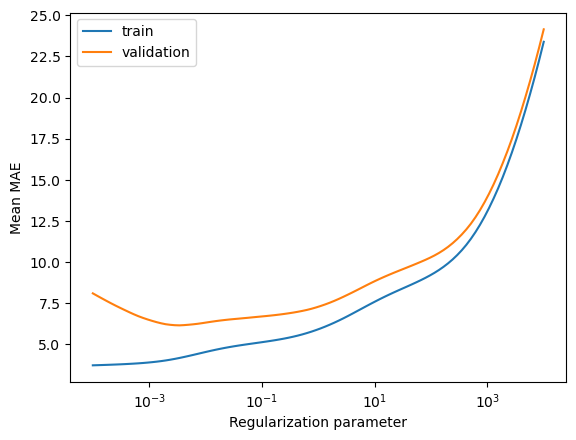

In [156]:
ax = sns.lineplot(x=alpha_values, y = -best_model.cv_results_['mean_train_score'], label='train')
ax = sns.lineplot(x=alpha_values, y = -best_model.cv_results_['mean_test_score'], label='validation')
ax.set_xscale('log')
ax.set_xlabel('Regularization parameter')
ax.set_ylabel('Mean MAE')
plt.legend(loc='upper left')
plt.show()

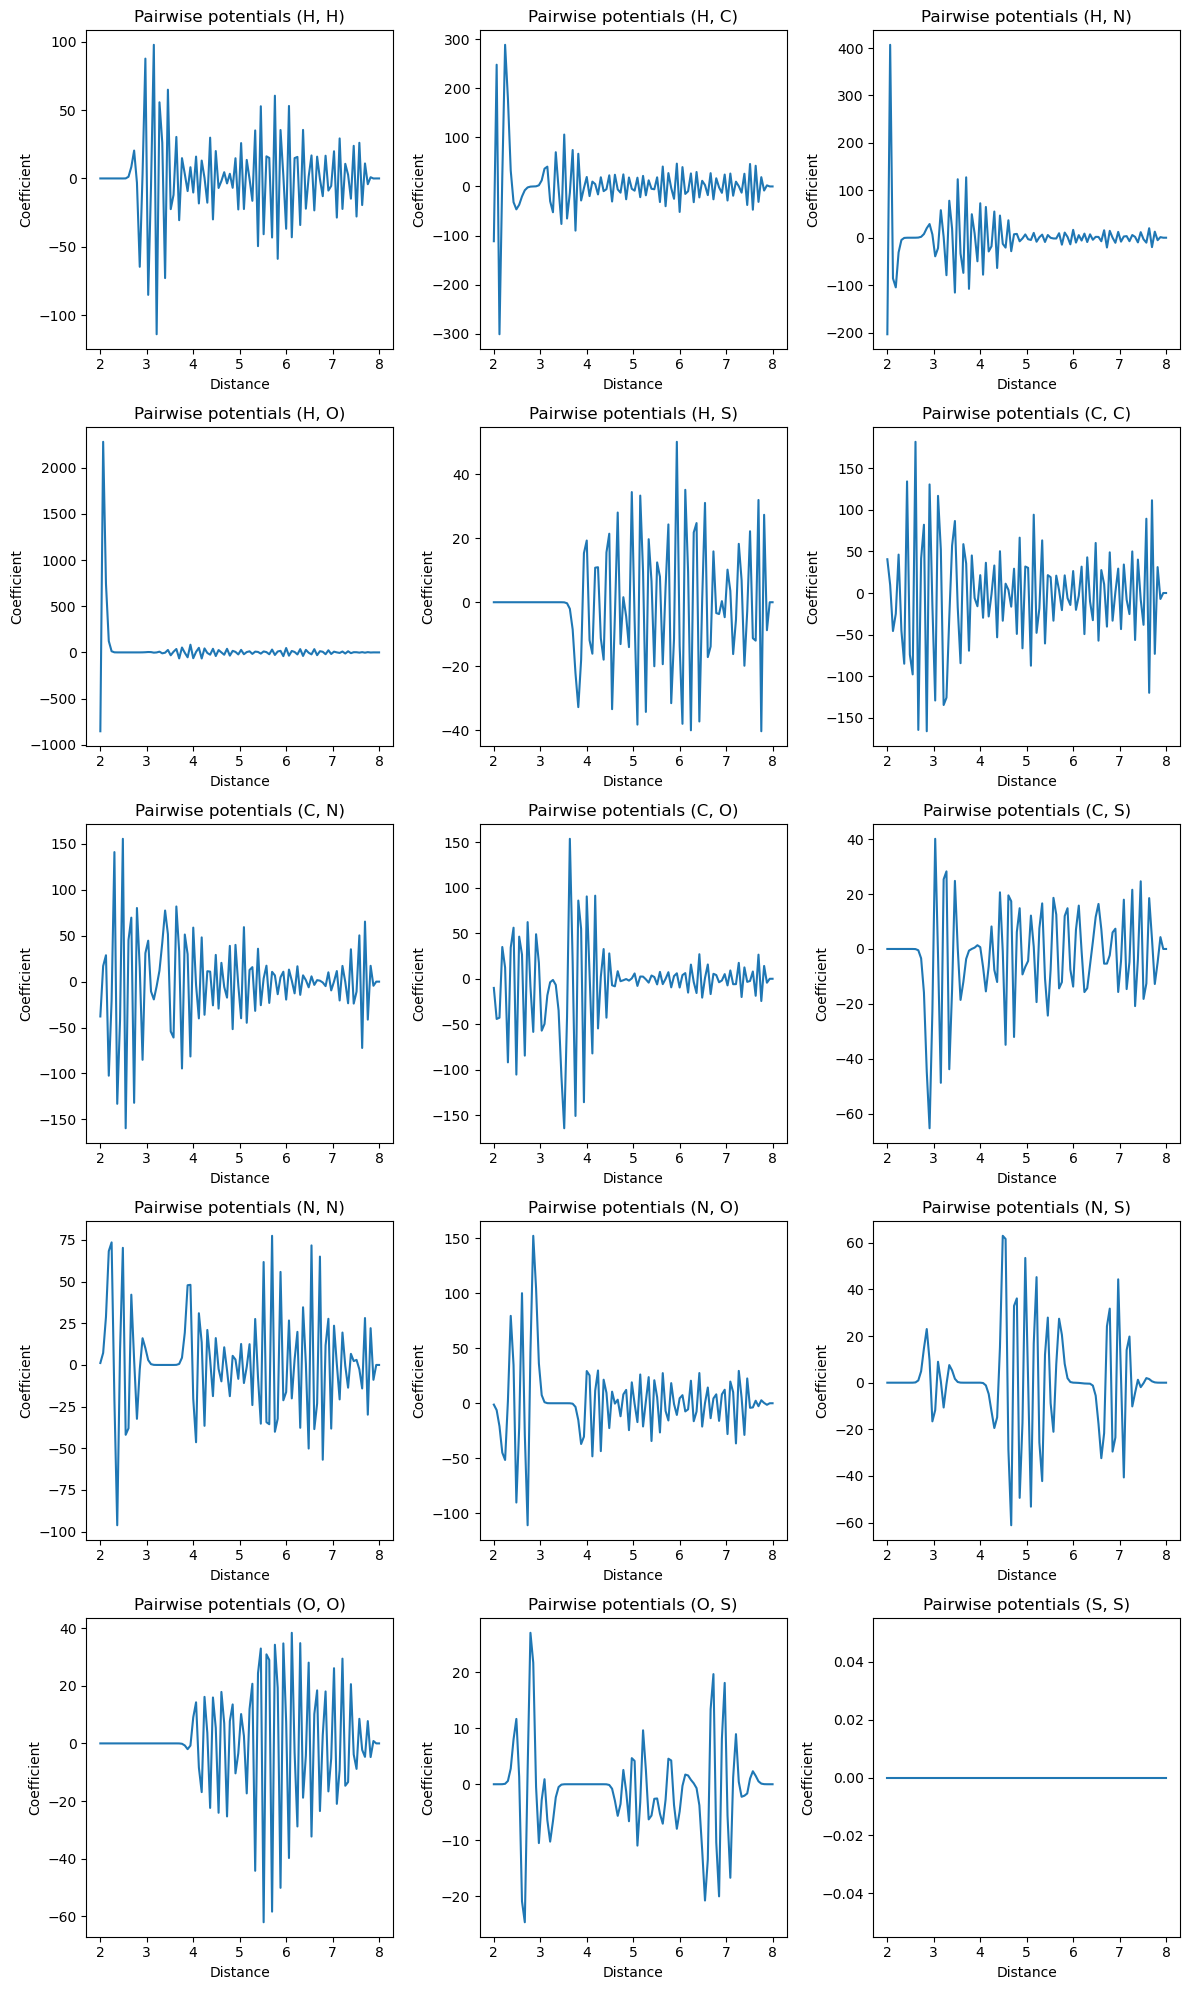

In [169]:
plot_pp(best_model.best_estimator_, **results[best_idx]['params'])

## best model in terms of explainability?

In [170]:
# look at numbers of coefficients higher then 1e-4
res_df.sort_values(by='n_coef_smaller_1e-4', ascending=False).head(20)

,M,STD,THETA_1,THETA_M,model_idx,best_score,best_alpha,n_coef_smaller_1e-4
60,100,0.01,2,4,60,-18.354541,242.012826,1422
62,100,0.02,2,4,62,-17.065375,79.248290,1359
63,100,0.02,2,8,63,-22.625587,95.454846,1308
61,100,0.01,2,8,61,-58.707161,10000.000000,1293
64,100,0.03,2,4,64,-16.834482,5.857021,1267
65,100,0.03,2,8,65,-9.663025,25.950242,1239
67,100,0.04,2,8,67,-9.393067,21.544347,1202
66,100,0.04,2,4,66,-14.313344,0.067342,1170
69,100,0.05,2,8,69,-9.304007,12.328467,1153
71,100,0.06,2,8,71,-9.327458,7.054802,1092


In [171]:
# chose idx 40 because many small indices but best score 
best_exp_idx = 60
best_model_exp = results[best_exp_idx]['search']
print("Best alpha:", best_model_exp.best_params_['alpha'])
print("Validation MAE:", -best_model_exp.best_score_)
print("Params:", results[best_exp_idx]['params'])

Best alpha: 242.01282647943833
Validation MAE: 18.354541342196928
Params: {'M': 100, 'STD': 0.01, 'THETA_1': 2, 'THETA_M': 4}


In [184]:
test_score = recreate_and_score(best_model_exp.best_estimator_, results[best_exp_idx]['params'], shuffled_index)
print("Test MAE:", test_score)

Test MAE: 16.659672694372283


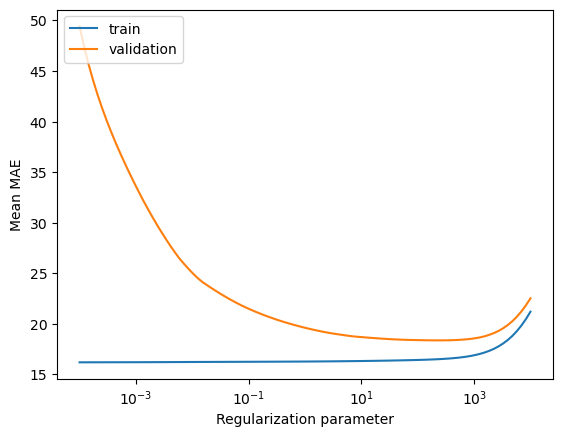

In [172]:
ax = sns.lineplot(x=alpha_values, y = -best_model_exp.cv_results_['mean_train_score'], label='train')
ax = sns.lineplot(x=alpha_values, y = -best_model_exp.cv_results_['mean_test_score'], label='validation')
ax.set_xscale('log')
ax.set_xlabel('Regularization parameter')
ax.set_ylabel('Mean MAE')
plt.legend(loc='upper left')
plt.show()

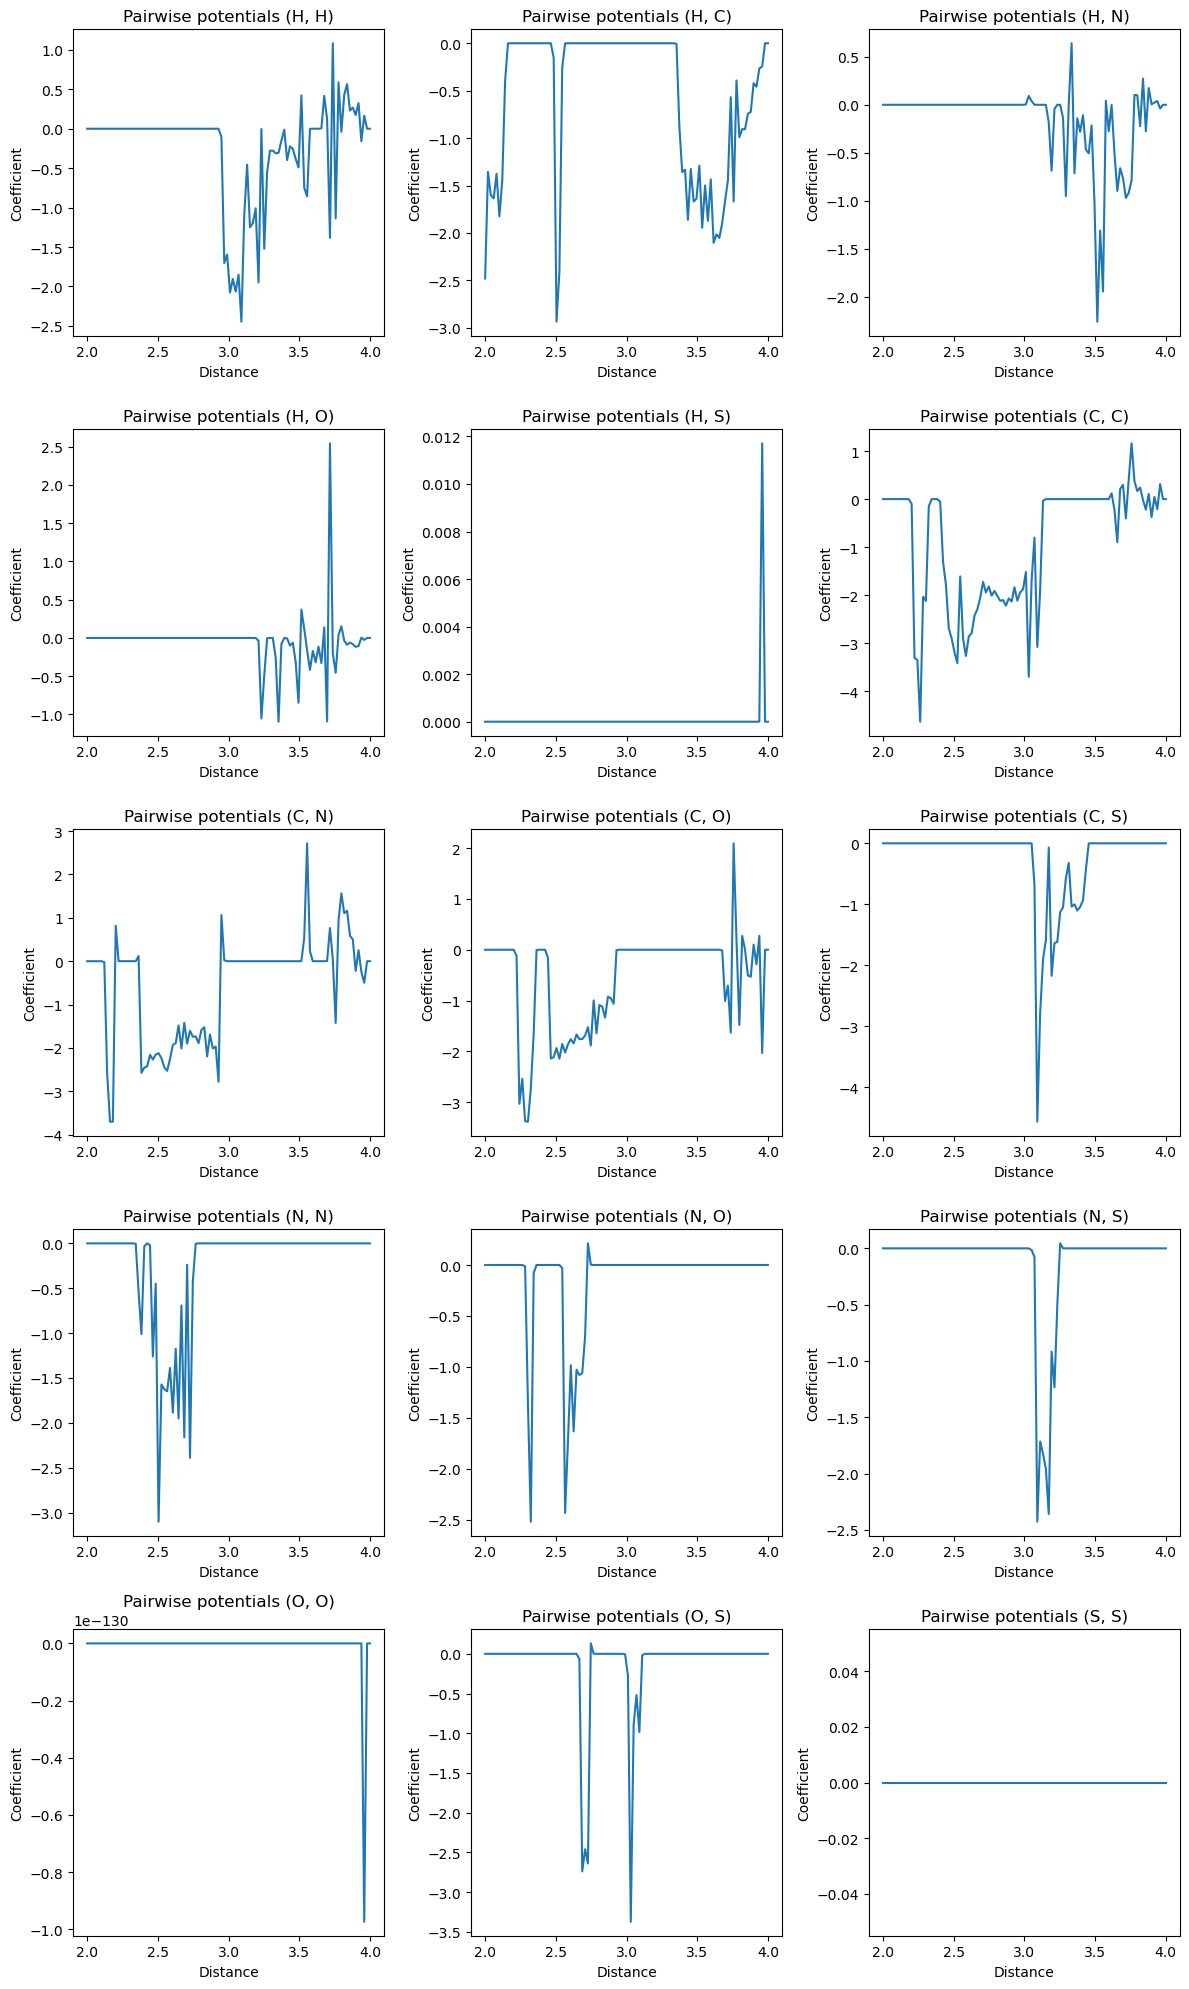

In [173]:
temp = res_df.iloc[best_exp_idx]
plot_pp(best_model_exp.best_estimator_, **results[best_exp_idx]['params'])

#### effect of shuffle

In [158]:
# TODO I noticed that shuffling the data seems to have an effect
# the molecules seem to have some kind of ordering, maybe some more complex at the last 30%?
# example only change if shuffle or not:

THETA_1 = 2
THETA_M = 4
STD = .1
M = 100
ALPHA = 0.0001

reps = generate_representaions(THETA_1, THETA_M, STD, M, soft=True)

# DONT SHUFFLE
X_train, X_test, y_train, y_test = split_and_center(reps, qm7["T"][0], test_size=0.3, shuffle=False)
model = Ridge(alpha=ALPHA, max_iter= 10000).fit(X_train, y_train)
print(f"MAE: {mean_absolute_error(y_test, model.predict(X_test)):.3f}")
    
# SHUFFLE
X_train, X_test, y_train, y_test = split_and_center(reps, qm7["T"][0], test_size=0.3, shuffle=True)
model = Ridge(alpha=ALPHA, max_iter= 10000).fit(X_train, y_train)
print(f"MAE: {mean_absolute_error(y_test, model.predict(X_test)):.3f}")

MAE: 28.842
MAE: 7.233


## MANUAL PARAMETER COMBINATION EXPERIMENT

In [134]:
THETA_1 = 2
THETA_M = 8
STD = .1
M = 100

# ALPHA = 10000

reps = generate_representaions(THETA_1, THETA_M, STD, M, soft=True)
X_train, X_test, y_train, y_test = split_and_center(reps, qm7["T"][0], test_size=0.2)
# fit_and_eval_model(Ridge, ALPHA, X_train, y_train, X_test, y_test,  M, THETA_1, THETA_M)

alpha_values = np.logspace(np.log10(1e-4), np.log10(10000), num=100)

ridge = Ridge()
grid = dict(alpha=alpha_values)
search = GridSearchCV(
    ridge,
    grid,
    scoring=("neg_mean_absolute_error"),
    cv=5,
    n_jobs=-1,
    refit="neg_mean_absolute_error",
    return_train_score=True,
)
search = search.fit(X_train, y_train)

print(search.best_score_, search.best_params_)


-6.0502046682224755 {'alpha': 0.003430469286314919}


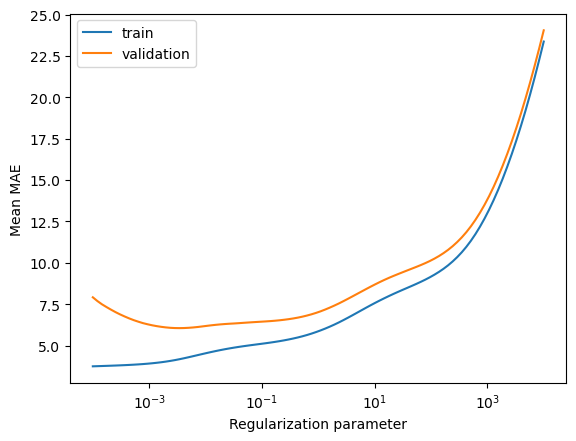

In [136]:
ax = sns.lineplot(x=alpha_values, y = -search.cv_results_['mean_train_score'], label='train')
ax = sns.lineplot(x=alpha_values, y = -search.cv_results_['mean_test_score'], label='validation')
ax.set_xscale('log')
ax.set_xlabel('Regularization parameter')
ax.set_ylabel('Mean MAE')
plt.legend(loc='upper left')
plt.show()

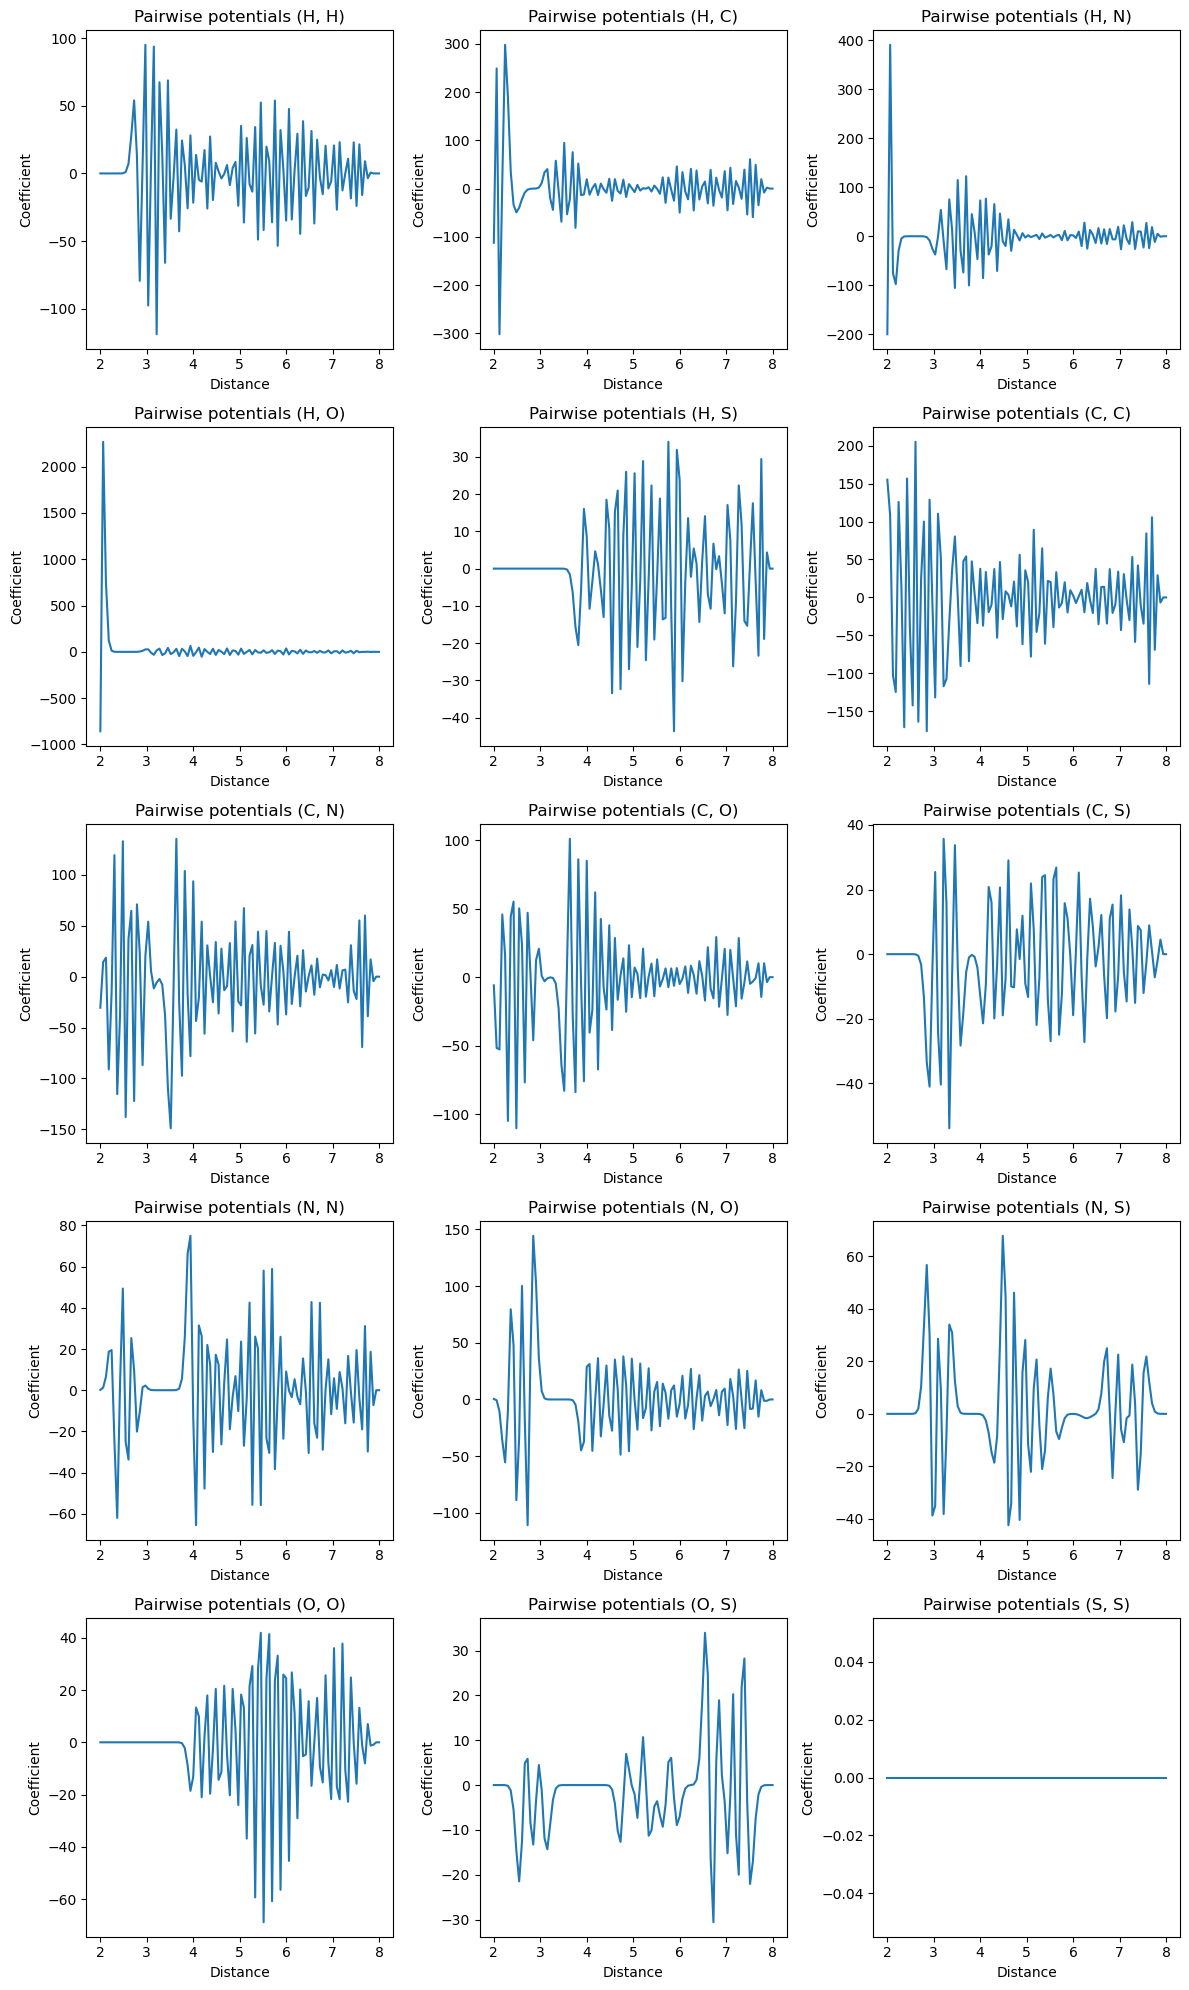

In [137]:
plot_pp(search.best_estimator_, M, THETA_1, THETA_M)

# EXPERIMENT **SOFT** encoding (theta range 2 - 8)
**See used parameters below**

MAE: 7.840
#coef = 0: 128
#coef < 1e-10: 854


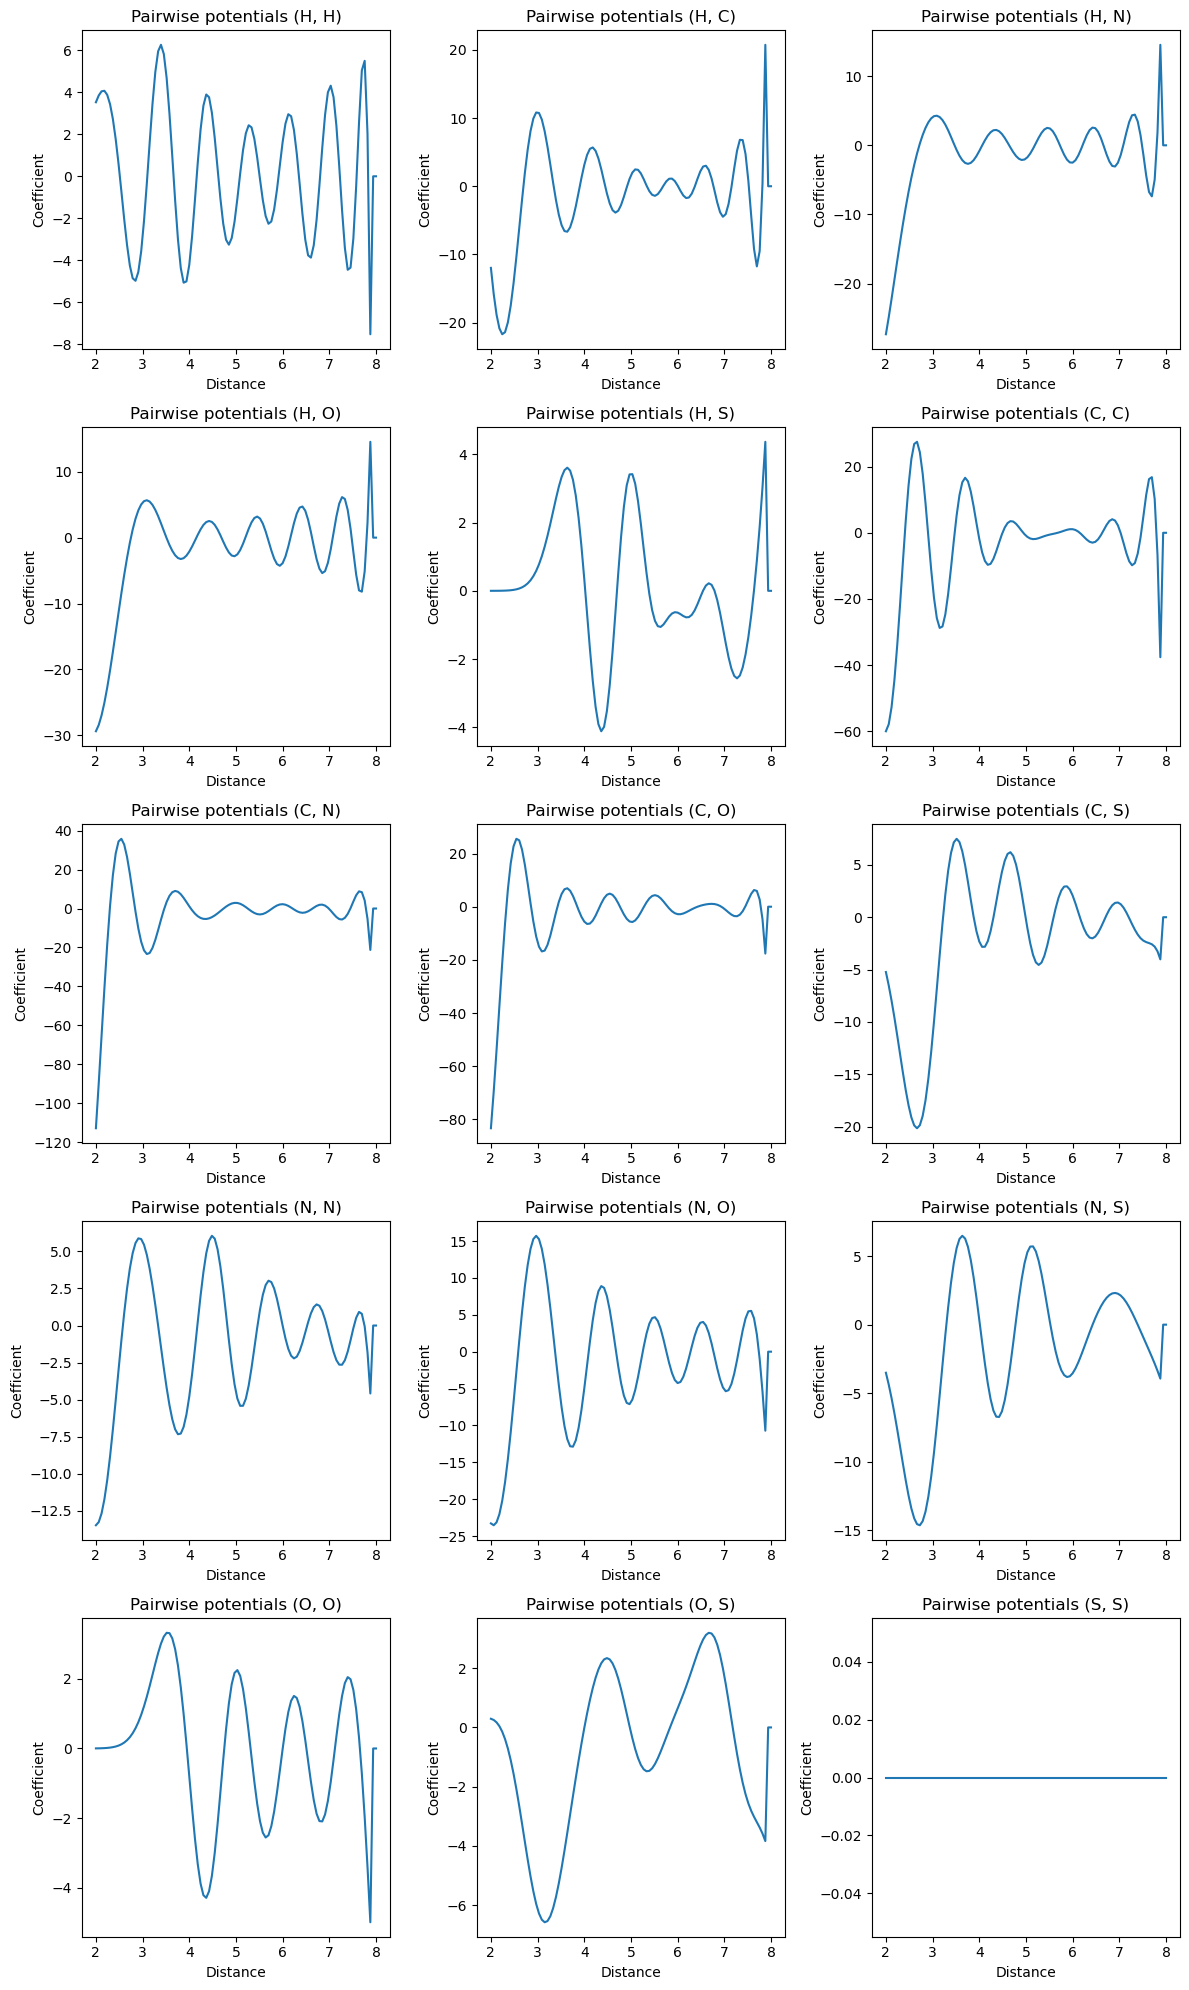

In [168]:
THETA_1 = 2
THETA_M = 8
STD = .5
M = 100

ALPHA = 1

reps = generate_representaions(THETA_1, THETA_M, STD, M, soft=True)
X_train, X_test, y_train, y_test = split_and_center(reps, qm7["T"][0], test_size=0.3)
fit_and_eval_model(Ridge, ALPHA, X_train, y_train, X_test, y_test,  M, THETA_1, THETA_M)


## RIDGE REG

MAE: 7.840
#coef = 0: 128
#coef < 1e-10: 854


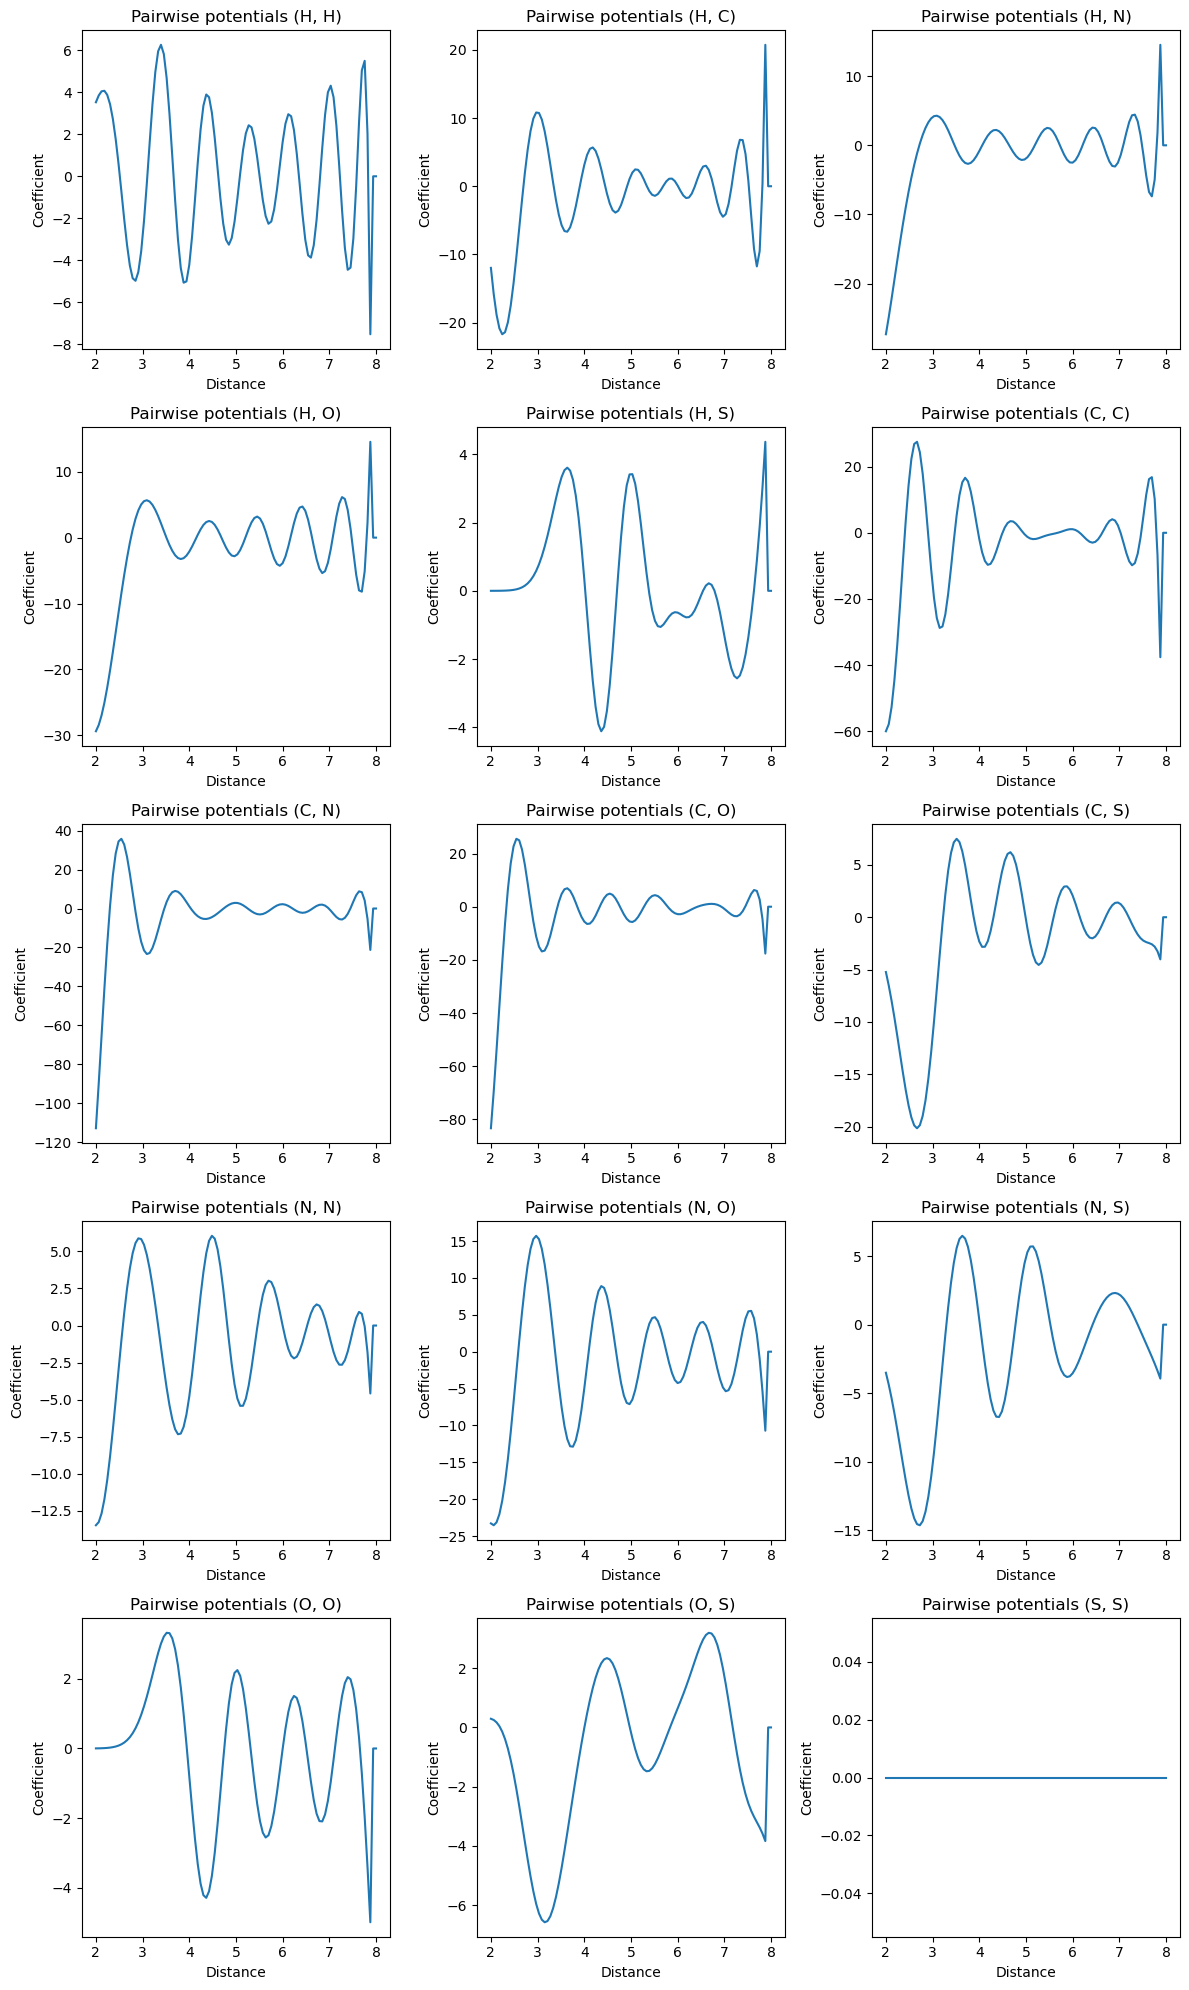

In [169]:
fit_and_eval_model(Ridge, ALPHA, X_train, y_train, X_test, y_test,  M, THETA_1, THETA_M)

## LASSO REG

MAE: 20.435
#coef = 0: 1436
#coef < 1e-10: 1497


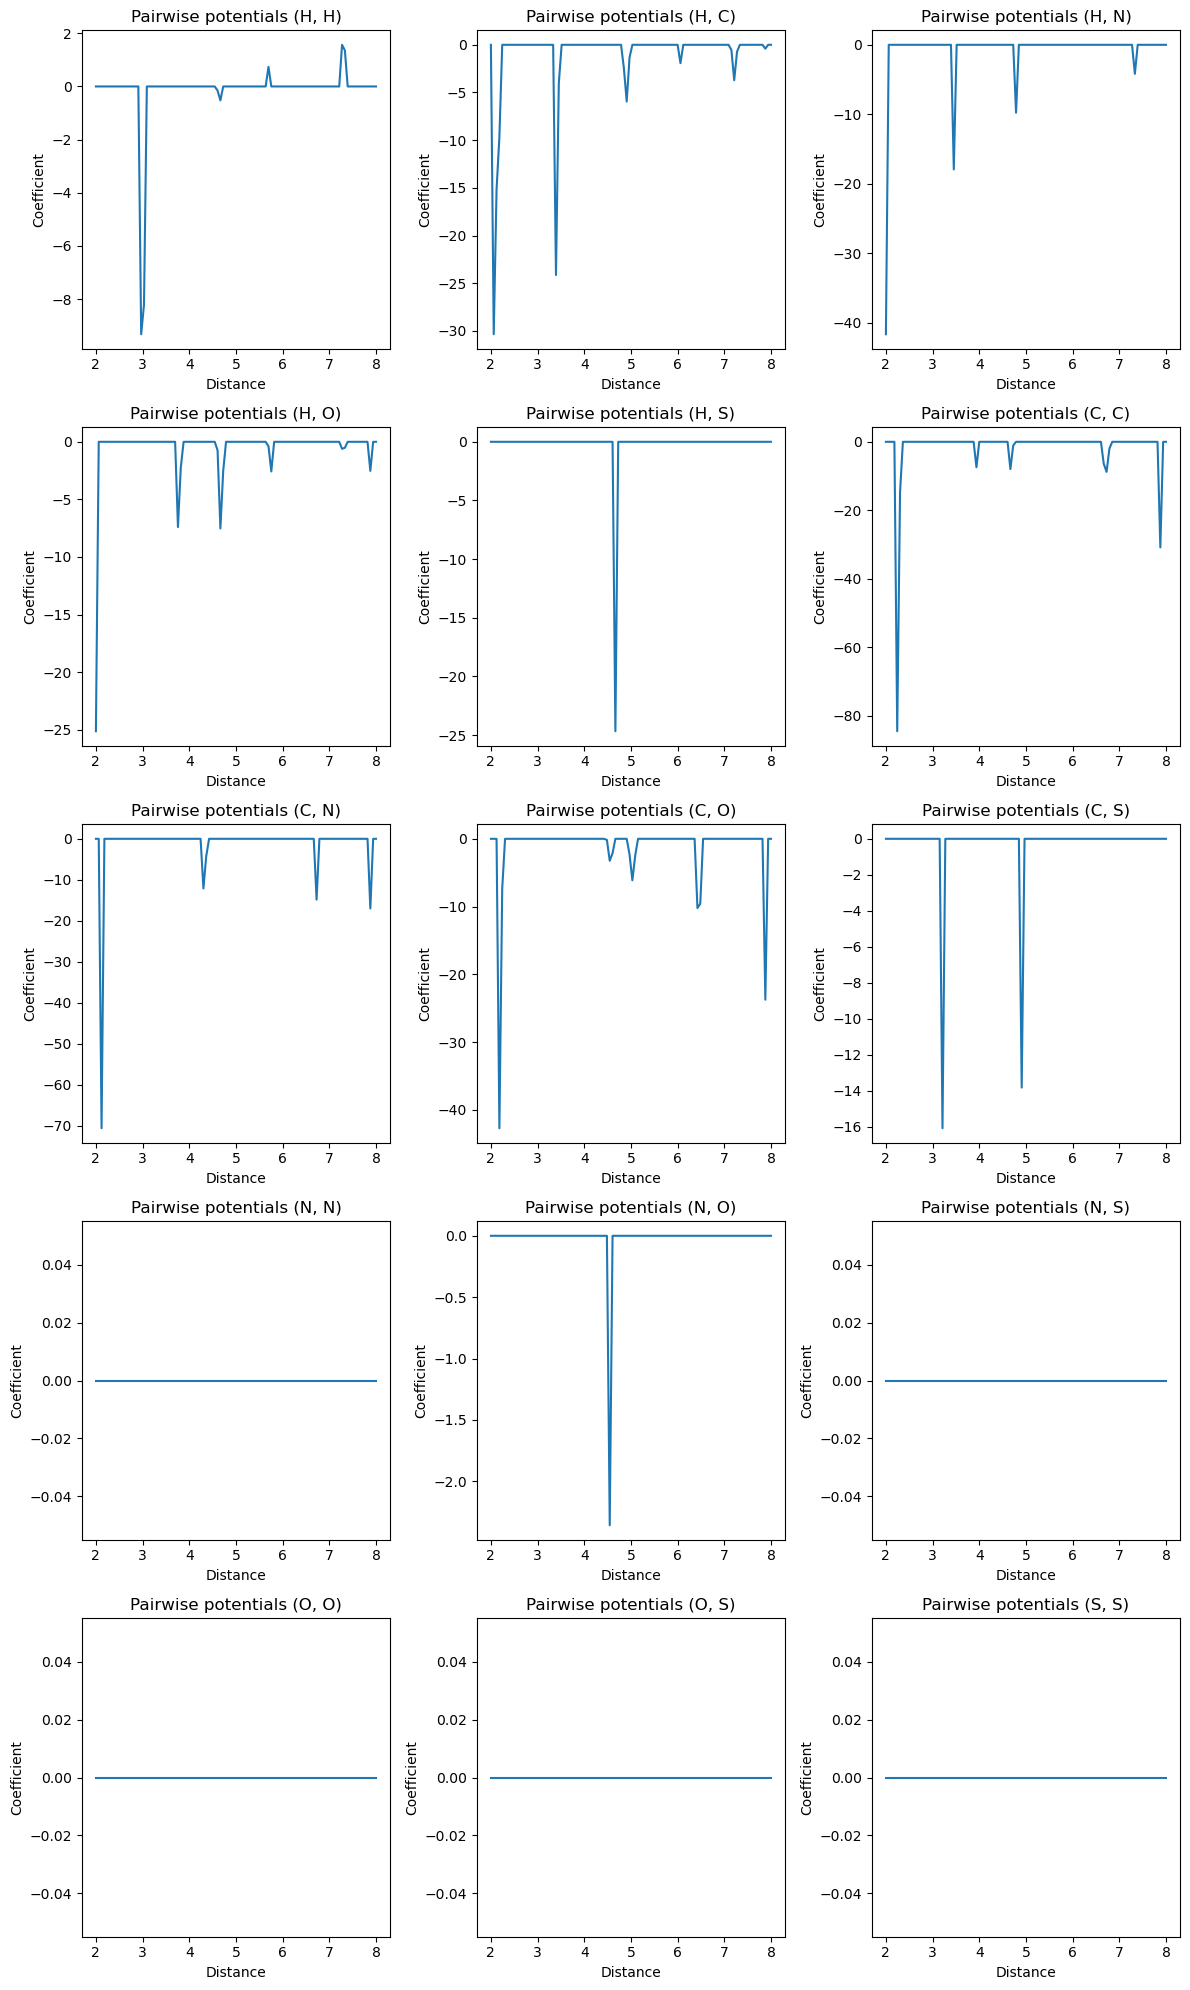

In [170]:
fit_and_eval_model(Lasso, ALPHA, X_train, y_train, X_test, y_test,  M, THETA_1, THETA_M)

# EXPERIMENT **HARD** encoding (same other parameters)

In [171]:
reps = generate_representaions(THETA_1, THETA_M, STD, M, soft=False)
X_train, X_test, y_train, y_test = split_and_center(reps, qm7["T"][0], test_size=0.3)

## RIDGE REG

MAE: 11.921
#coef = 0: 570
#coef < 1e-10: 1303


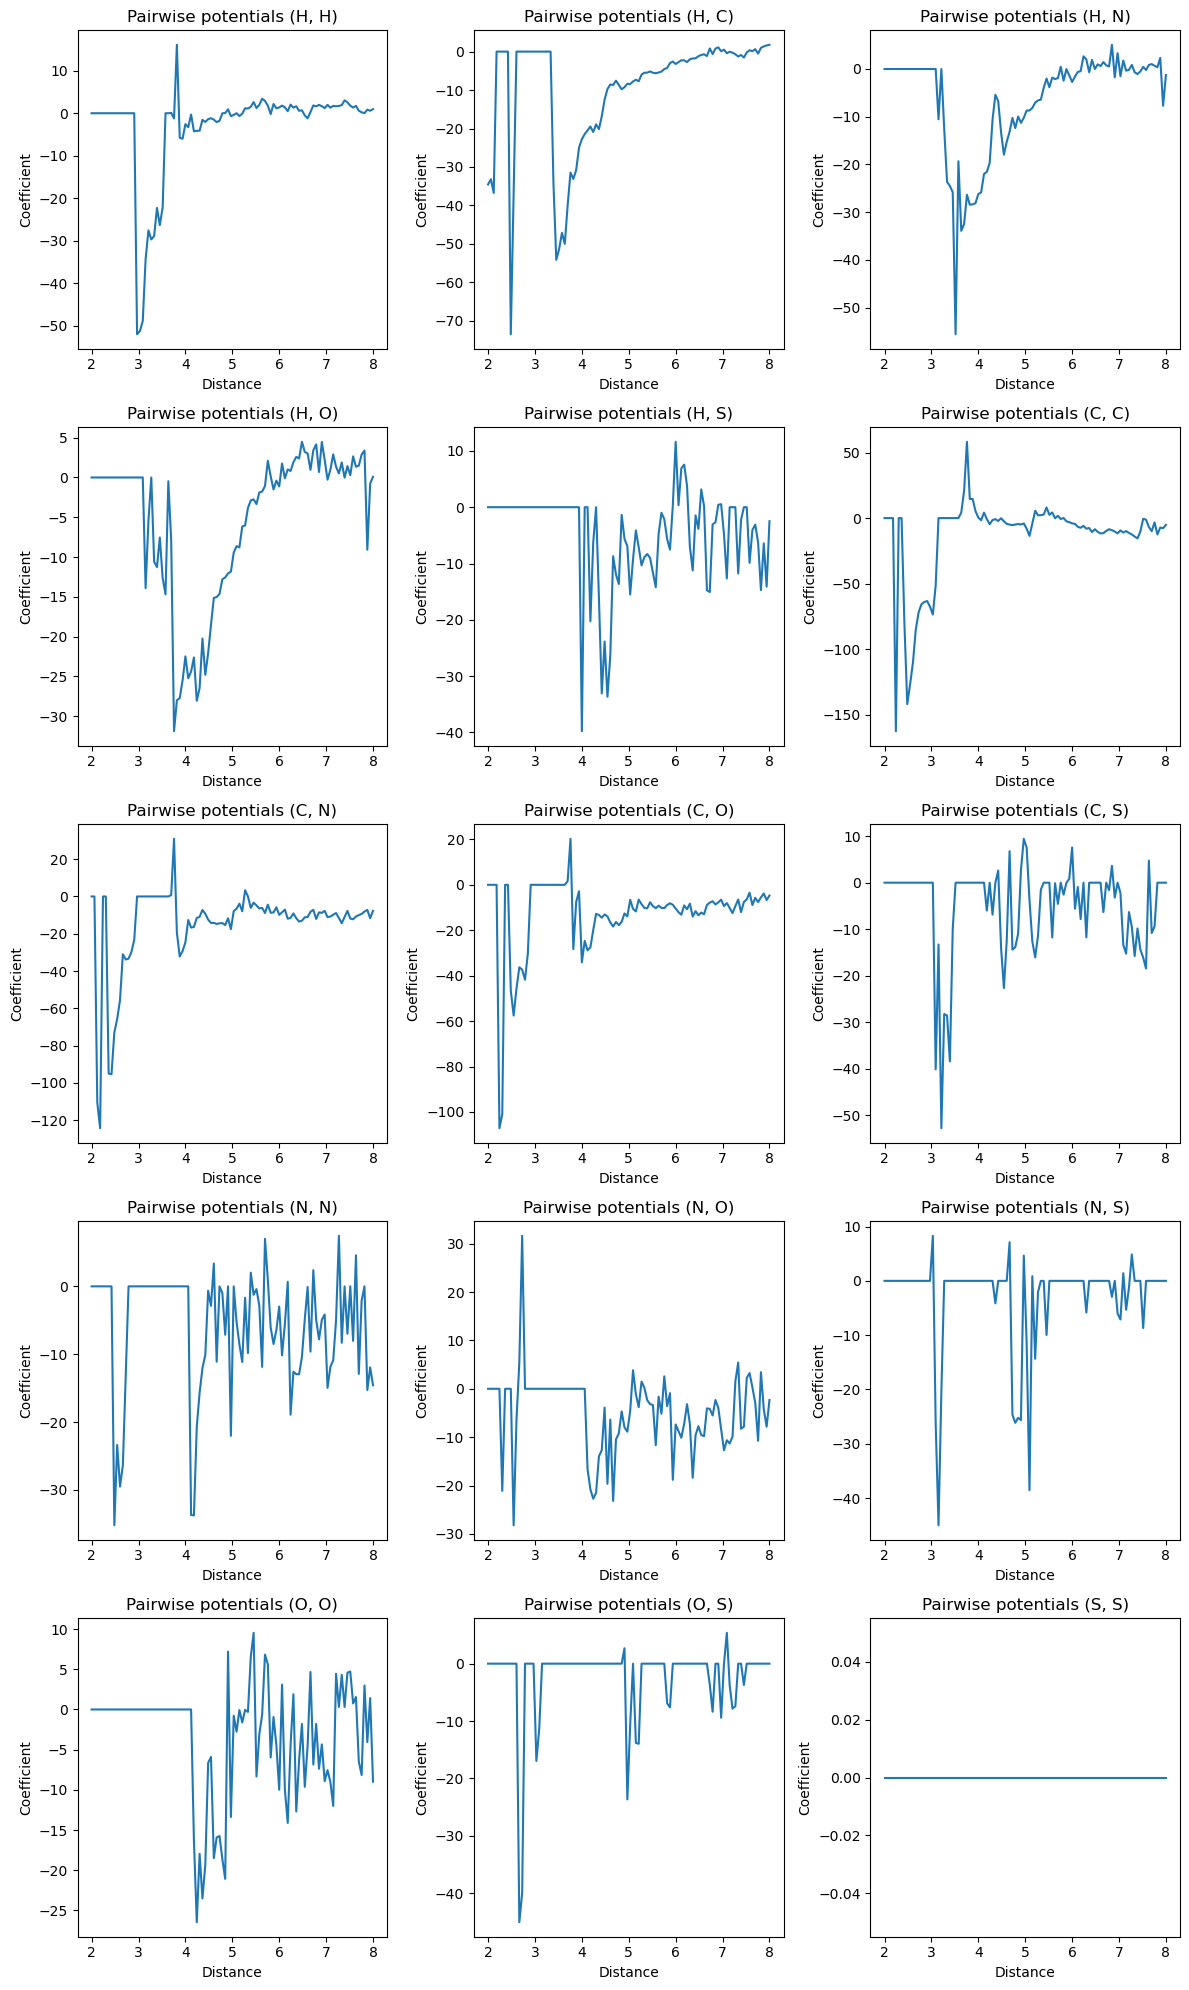

In [172]:
fit_and_eval_model(Ridge, ALPHA, X_train, y_train, X_test, y_test,  M, THETA_1, THETA_M)

## LASSO REG

MAE: 40.020
#coef = 0: 1390
#coef < 1e-10: 1492


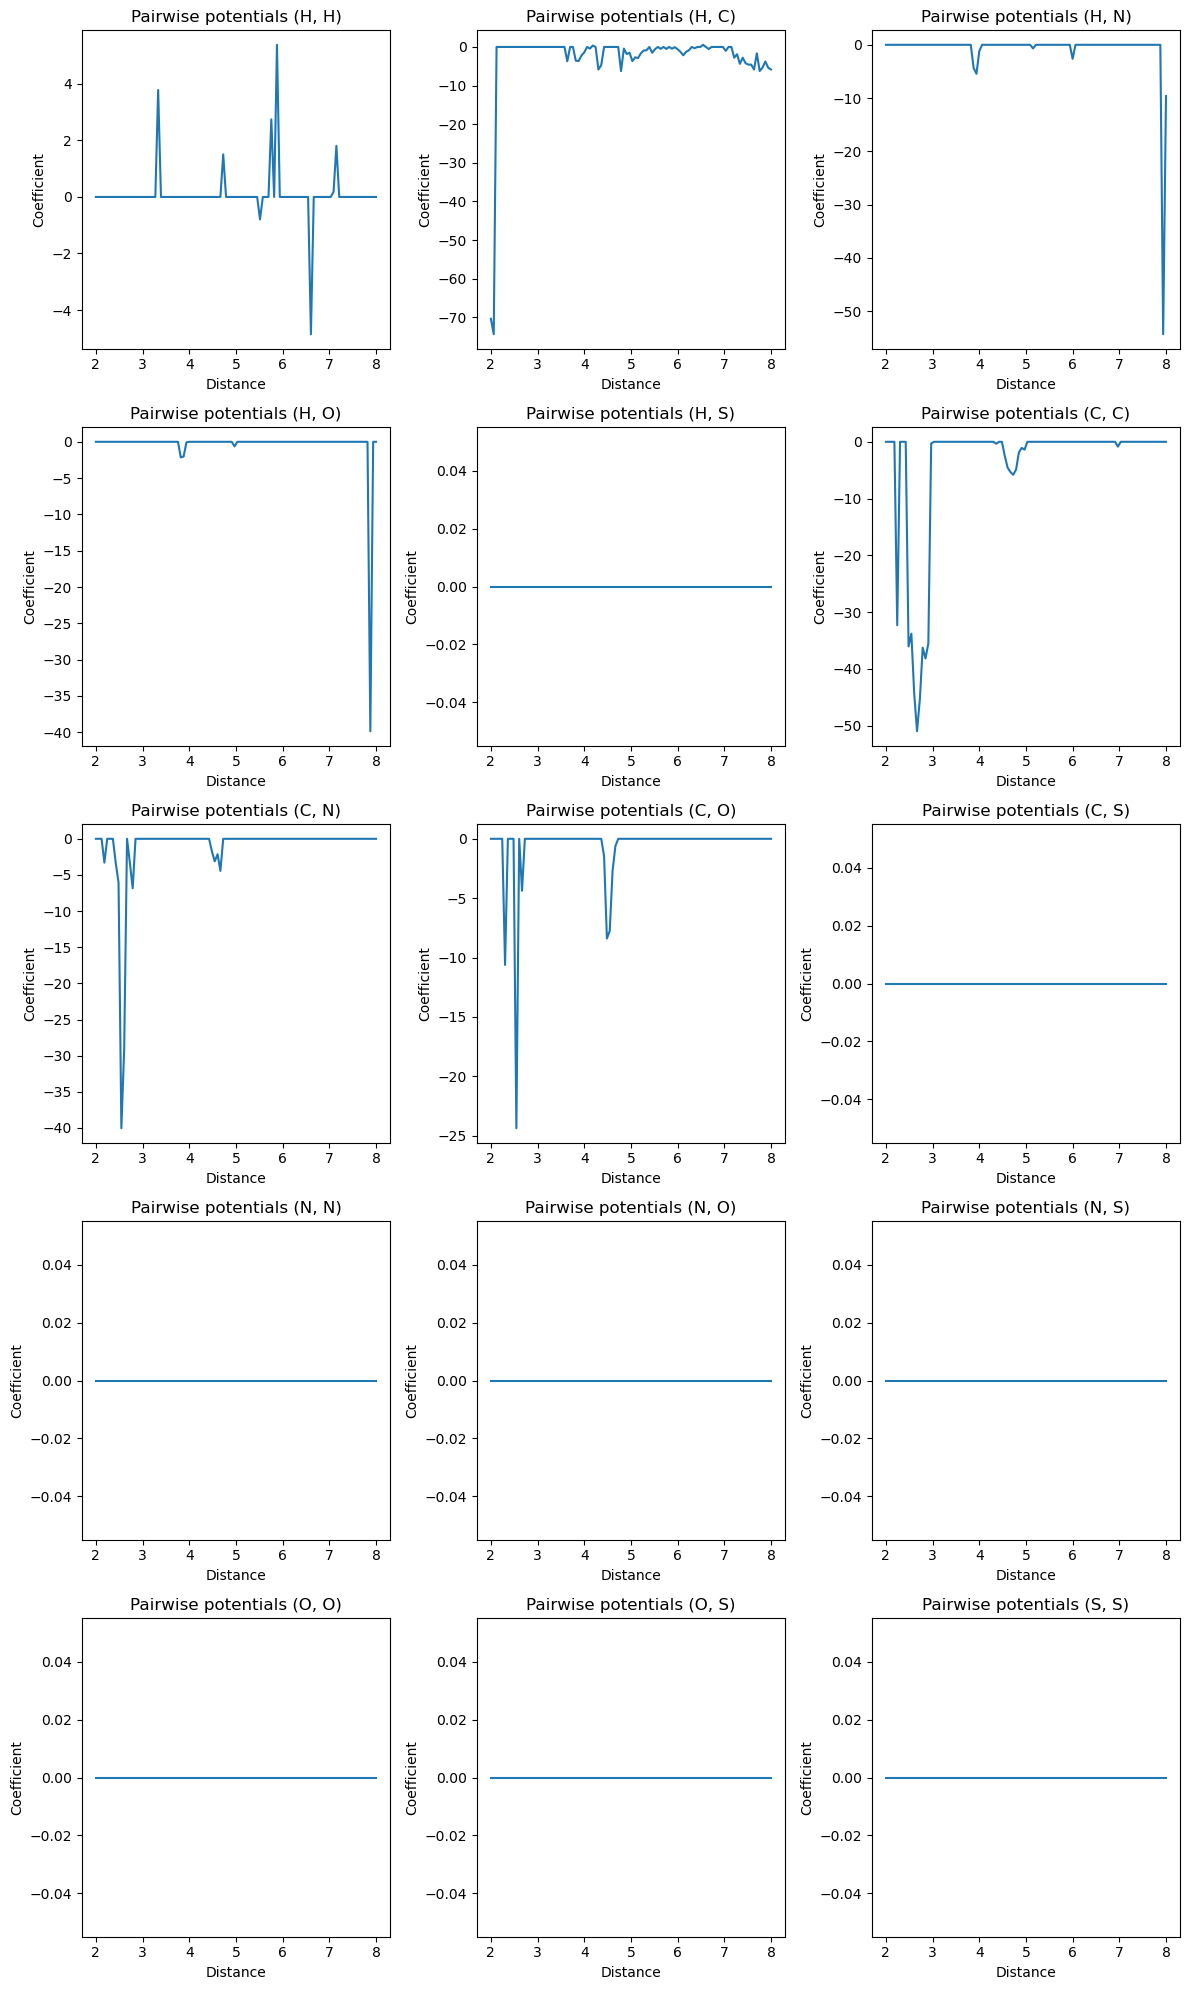

In [173]:
fit_and_eval_model(Lasso, ALPHA, X_train, y_train, X_test, y_test,  M, THETA_1, THETA_M)